In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis_sol
import matplotlib.pyplot as plti
import numpy as np
importlib.reload(kgs)
#pack_vis.plot_polygons([kgs.center_tree] + kgs.convex_breakdown)

local
local


<module 'kaggle_support' from '/mnt/d/packing/code/analysis/../core/kaggle_support.py'>

In [7]:
# Compare final scores across multiple seeds
SEEDS_TO_DO = [140,141]
TREES_TO_DO = np.arange(62,121,2)
#SEEDS_TO_DO = [110,111]

import numpy as np
import glob
import matplotlib.pyplot as plt
import re

res = []
for s in SEEDS_TO_DO:
    res.append([])
    for N_trees in TREES_TO_DO:
        f = kgs.temp_dir+f'controller_runs/done/ga_N{N_trees}_seed{s}_done.pickle'
        dat = kgs.dill_load(f)
        res[-1].append(dat.ga.champions[0].phenotype.h[0,0].get()**2/N_trees)

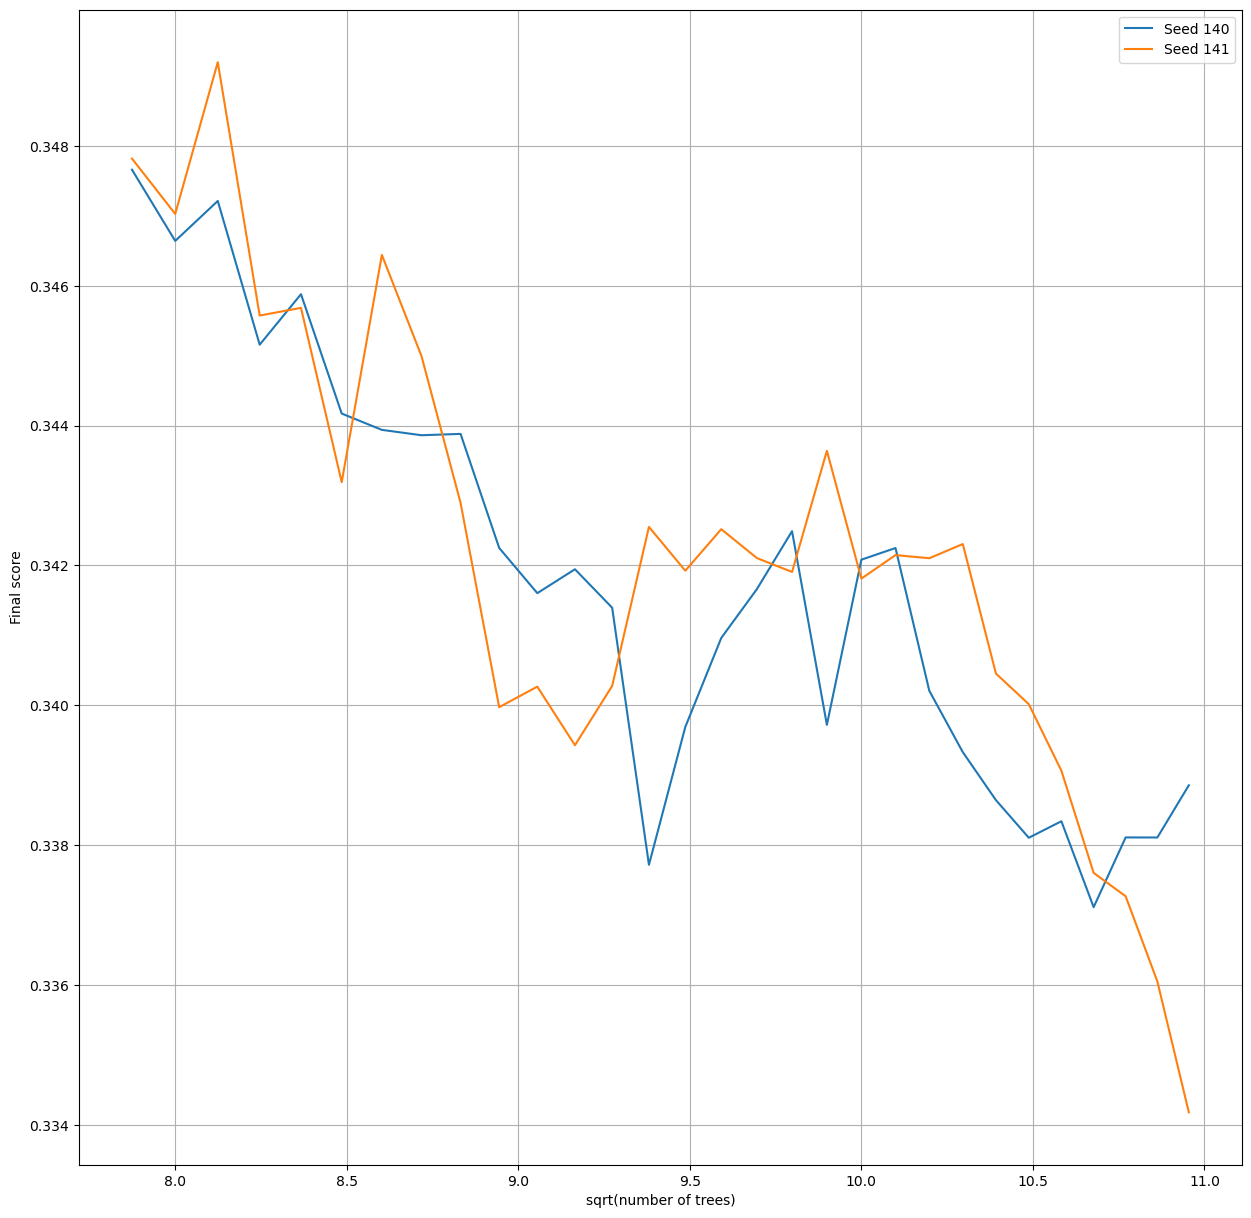

In [8]:
plt.figure(figsize=(15,15))
for i, s in enumerate(SEEDS_TO_DO):
    plt.plot(np.sqrt(TREES_TO_DO), res[i], label=f'Seed {s}')
plt.xlabel('sqrt(number of trees)')
plt.ylabel('Final score')
plt.legend()
plt.grid(True)

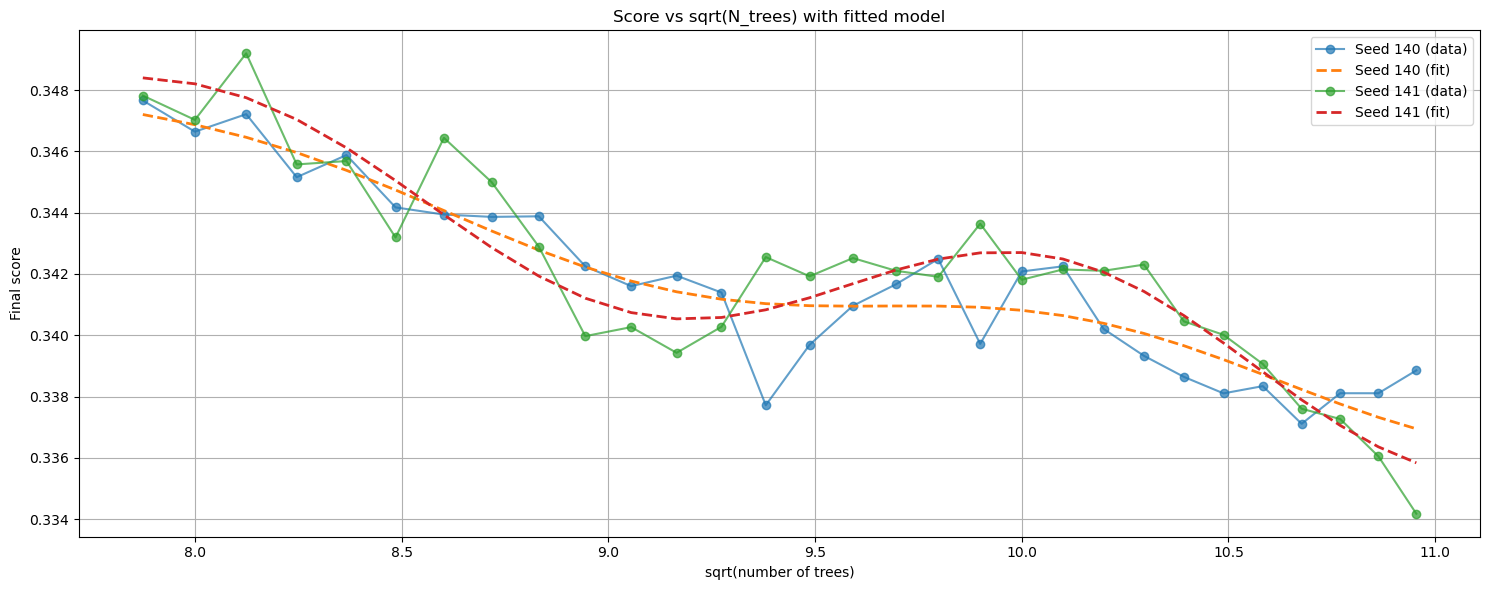

In [11]:
# do a linear fit (independent per seed) of score = a/sqrt(N_trees) + b + c*sin(pi*sqrt(N_trees)) + d*cos(pi*sqrt(N_trees))
# use sklearn

from sklearn.linear_model import LinearRegression

sqrt_N_trees = np.sqrt(TREES_TO_DO)

# Create feature matrix: [1/sqrt(N_trees), 1, sin(pi*sqrt(N_trees)), cos(pi*sqrt(N_trees))]
X = np.column_stack([
    1.0 / sqrt_N_trees,
    np.ones_like(sqrt_N_trees),
    sqrt_N_trees*np.sin(np.pi * sqrt_N_trees),
    sqrt_N_trees*np.cos(np.pi * sqrt_N_trees)
])

# Fit model for each seed
models = []
for i, s in enumerate(SEEDS_TO_DO):
    model = LinearRegression()
    model.fit(X, res[i])
    models.append(model)
    
    # Print results
    # print(f"Seed {s}:")
    # print(f"  a (1/sqrt(N)) coefficient: {model.coef_[0]:.6f}")
    # print(f"  b (constant) coefficient: {model.coef_[1]:.6f}")
    # print(f"  c (sin) coefficient: {model.coef_[2]:.6f}")
    # print(f"  d (cos) coefficient: {model.coef_[3]:.6f}")
    # print(f"  R² score: {model.score(X, res[i]):.6f}")
    # print()

# Plot fitted curves
plt.figure(figsize=(15, 6))
for i, s in enumerate(SEEDS_TO_DO):
    y_pred = models[i].predict(X)
    plt.plot(sqrt_N_trees, res[i], 'o-', label=f'Seed {s} (data)', alpha=0.7)
    plt.plot(sqrt_N_trees, y_pred, '--', label=f'Seed {s} (fit)', linewidth=2)

plt.xlabel('sqrt(number of trees)')
plt.ylabel('Final score')
plt.legend()
plt.grid(True)
plt.title('Score vs sqrt(N_trees) with fitted model')
plt.tight_layout()


Seed 140 (with fitted frequency and amplitude scaling):
  a (1/sqrt(N)) coefficient: 0.234883
  b (constant) coefficient: 0.316661
  c (sin) coefficient: 0.000014
  d (cos) coefficient: 0.000959
  ω (frequency): 3.781548
  (frequency/π): 1.203704
  α (amplitude exponent): 0.000000
  Harmonic amplitude: 0.000959
  Phase (radians): 1.556510
  Phase (degrees): 89.18
  R² score: 0.880145

Seed 141 (with fitted frequency and amplitude scaling):
  a (1/sqrt(N)) coefficient: 0.236566
  b (constant) coefficient: 0.316778
  c (sin) coefficient: 0.000019
  d (cos) coefficient: 0.000015
  ω (frequency): 3.217940
  (frequency/π): 1.024302
  α (amplitude exponent): 2.000000
  Harmonic amplitude: 0.000025
  Phase (radians): 0.655045
  Phase (degrees): 37.53
  R² score: 0.905191



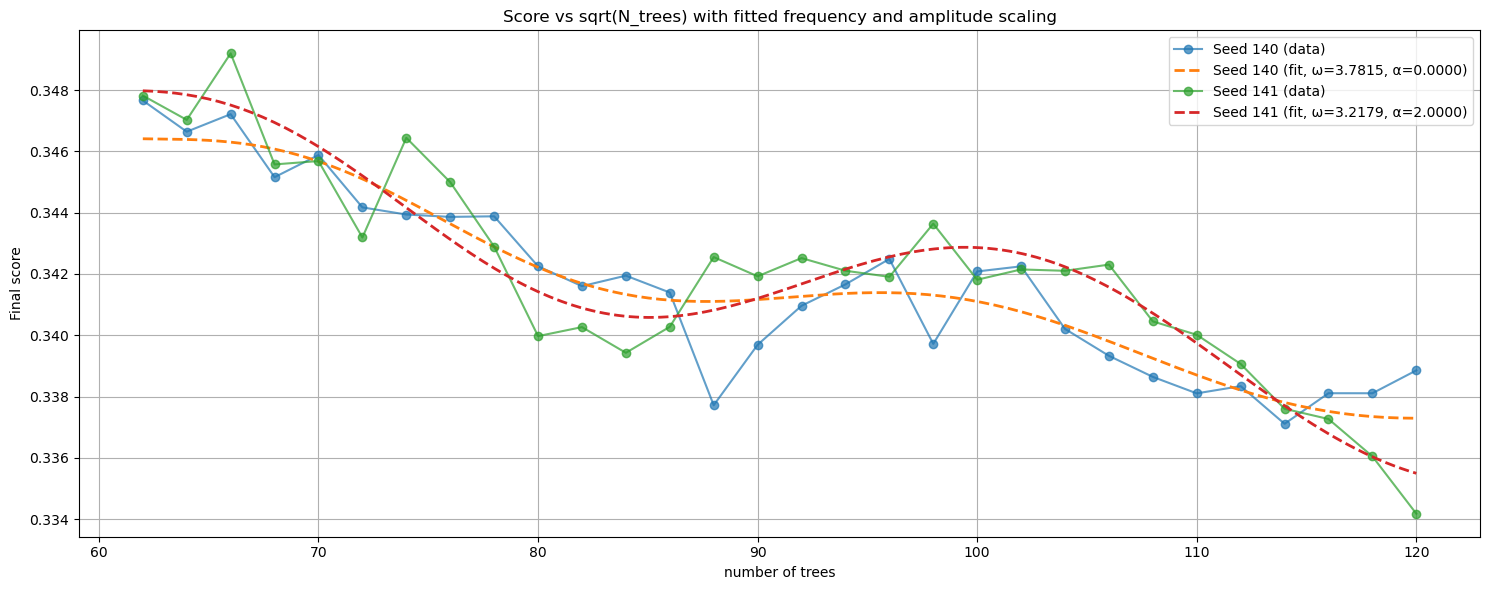

In [12]:
from scipy.optimize import curve_fit

# Define the model function with frequency and amplitude scaling as parameters
def model(sqrt_N, a, b, c, d, omega, alpha):
    amplitude = sqrt_N ** alpha
    return a / sqrt_N + b + amplitude * (c * np.sin(omega * sqrt_N) + d * np.cos(omega * sqrt_N))

sqrt_N_trees = np.sqrt(TREES_TO_DO)

# Fit with frequency and amplitude exponent as constrained parameters
fitted_params = []
for i, s in enumerate(SEEDS_TO_DO):
    # Bounds: (a_min, b_min, c_min, d_min, omega_min, alpha_min) to (max...)
    bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, 2.0, 0.0], 
              [np.inf, np.inf, np.inf, np.inf, 4.5, 2.0])  # Keep omega [2, 4.5] and alpha [0, 2]
    
    try:
        popt, pcov = curve_fit(
            model, 
            sqrt_N_trees, 
            res[i],
            p0=[models[i].coef_[0], models[i].coef_[1], models[i].coef_[2], models[i].coef_[3], np.pi, 1.0],
            bounds=bounds,
            maxfev=5000
        )
        fitted_params.append(popt)
        
        # Calculate R² manually
        y_pred = model(sqrt_N_trees, *popt)
        ss_res = np.sum((np.array(res[i]) - y_pred) ** 2)
        ss_tot = np.sum((np.array(res[i]) - np.mean(res[i])) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        # Print results
        print(f"Seed {s} (with fitted frequency and amplitude scaling):")
        print(f"  a (1/sqrt(N)) coefficient: {popt[0]:.6f}")
        print(f"  b (constant) coefficient: {popt[1]:.6f}")
        print(f"  c (sin) coefficient: {popt[2]:.6f}")
        print(f"  d (cos) coefficient: {popt[3]:.6f}")
        print(f"  ω (frequency): {popt[4]:.6f}")
        print(f"  (frequency/π): {popt[4]/np.pi:.6f}")
        print(f"  α (amplitude exponent): {popt[5]:.6f}")
        
        # Calculate amplitude and phase from c and d
        harmonic_amp = np.sqrt(popt[2]**2 + popt[3]**2)
        phase = np.arctan2(popt[3], popt[2])
        print(f"  Harmonic amplitude: {harmonic_amp:.6f}")
        print(f"  Phase (radians): {phase:.6f}")
        print(f"  Phase (degrees): {np.degrees(phase):.2f}")
        
        print(f"  R² score: {r2:.6f}")
        print()
    except Exception as e:
        print(f"Failed to fit seed {s}: {e}")
        print()

# Plot fitted curves with optimized frequency and amplitude
plt.figure(figsize=(15, 6))
sqrt_N_fine = np.linspace(sqrt_N_trees.min(), sqrt_N_trees.max(), 200)

y_preds=[]
for i, s in enumerate(SEEDS_TO_DO):
    if i < len(fitted_params):
        y_pred = model(sqrt_N_trees, *fitted_params[i])
        plt.plot(sqrt_N_trees**2, res[i], 'o-', label=f'Seed {s} (data)', alpha=0.7)
        plt.plot(sqrt_N_fine**2, model(sqrt_N_fine, *fitted_params[i]), '--', label=f'Seed {s} (fit, ω={fitted_params[i][4]:.4f}, α={fitted_params[i][5]:.4f})', linewidth=2)
        y_preds.append(model(sqrt_N_trees, *fitted_params[i]))

val = 1.006
switch = 53
skip1_list = np.array(TREES_TO_DO)[y_preds[0]>val*y_preds[1]]
skip1_list = skip1_list[skip1_list>=switch]

# Add red crosses over y_pred values for skip1_list entries
for skip_N in skip1_list:
    idx = np.argmin(np.abs(TREES_TO_DO - skip_N))
    y_pred_val = res[0][idx]
    plt.plot(skip_N, y_pred_val, 'x', color='red', markersize=10, markeredgewidth=2)

skip2_list = np.array(TREES_TO_DO)[y_preds[1]>val*y_preds[0]]
skip2_list = skip2_list[skip2_list>=switch]

#Add red crosses over y_pred values for skip1_list entries
for skip_N in skip2_list:
    idx = np.argmin(np.abs(TREES_TO_DO - skip_N))
    y_pred_val = res[1][idx]
    plt.plot(skip_N, y_pred_val, 'x', color='red', markersize=10, markeredgewidth=2)

plt.xlabel('number of trees')
plt.ylabel('Final score')
plt.legend()
plt.grid(True)
plt.title('Score vs sqrt(N_trees) with fitted frequency and amplitude scaling')
plt.tight_layout()

#kgs.dill_save(kgs.code_dir + 'skip_list.pickle', (skip1_list, skip2_list))


In [ ]:
y_preds[0]/y_preds[1]

array([0.99875685, 1.00278675, 1.00416719, 1.00232723, 0.99835179,
       0.99417445, 0.9916043 , 0.9916367 , 0.99421298, 0.9983838 ,
       1.00273138, 1.00587514, 1.00689558, 1.00556012, 1.00231445,
       0.99808385, 0.99397886, 0.99100348, 0.98983536, 0.99070994,
       0.99341046, 0.99734773, 1.00170392, 1.0056087 , 1.00831281,
       1.0093257 , 1.00849217, 1.00599788, 1.00231029, 0.99807529,
       0.99399541, 0.990714  , 0.98872277, 0.98830179, 0.98949462,
       0.99211625, 0.99578939, 1.00000285, 1.00418434, 1.00777855,
       1.0103204 , 1.01149349, 1.01116577, 1.00939834, 1.00642768,
       1.00262624, 0.99844935, 0.99437702, 0.99085892, 0.98826819,
       0.98686771, 0.98679012, 0.98803147, 0.99045738, 0.99382034,
       0.99778613, 1.00196726, 1.00596076, 1.00938686, 1.01192516,
       1.01334431, 1.01352218, 1.0124544 , 1.01025057, 1.00711942,
       1.00334515, 0.99925834, 0.99520506, 0.99151719, 0.98848662,
       0.98634483, 0.98524859, 0.98527201, 0.98640461, 0.98855